
### Maintenance dredging due to keeping the port accessible


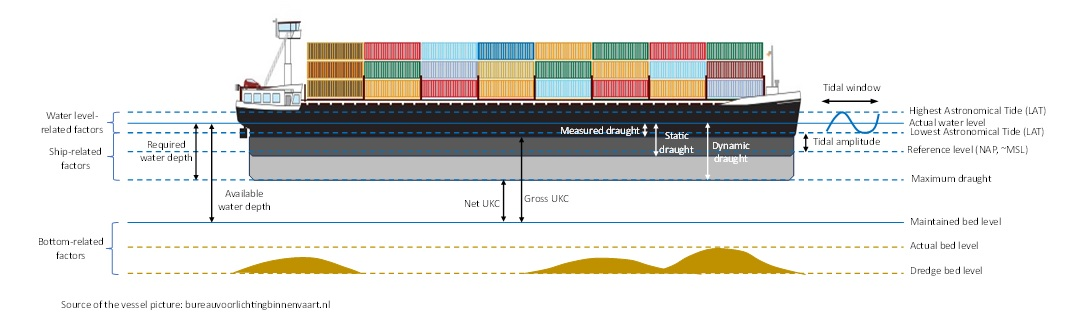



This notebook aims to formulate the port accessibility in openclsim simulation when addressing the interaction between one dredging vessel and one seagoing vessel.


The concept of accessibility is defined based on the picture above. When the available water depth is higher than the required water depth for the seagoing vessel, the vessel can sail through the port. Otherwise, the dredging vessel should start its job and keep the port accessible by dredging a certain amount of sediment.

required water depth = draught + safety margin for under keel clearance


if lowest astronomical tide > actual water level:

available water depth = lowest astronomical tide - maintained bed level

if lowest astronomical tide < actual water level:

available water depth = actual water depth - maintained bed level

#### 0. Import libraries

In [100]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

#### 1. Initialise simpy environment

In [101]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [102]:
# create a Site object based on desired mixin classes
Site = type(
    'Site',
    (core.Identifiable,
    core.Log,
    core.Locatable,
    core.HasContainer,
    core.HasResource,
    core.HasActualWaterLevel,
    core.HasLowestAstronomicalTide,
    core.HasMaintainedBedLevel,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable,
        core.HasResource,
        core.HasContainer,
        core.Processor,
        core.Identifiable,
        core.Log,
        core.LoadingFunction,
        core.UnloadingFunction,
        core.HasDraught,   # adding the draught attibute for vessel objects
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata,
    ),
    {},
)

AttributeError: module 'openclsim.core' has no attribute 'HasMaintainedBedLevel'

#### 3. Create objects

##### 3.1. Create site objects

In [ ]:
# prepare input data for offshore
location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 0,
                }
offshore = Site(**data_offshore)

# prepare input data for berth
location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 80,
              "nr_resources": 1
             }
berth = Site(**data_berth)

# prepare input data for dump
location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
dump = Site(**data_dump) 

##### 3.2. Create vessel objects

In [ ]:
# prepare input data for vessel_01 (dredging vessel)
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_dump, 
    "capacity": 10,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x,
    "draught": 10,
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
assert not vessel01.metadata


# prepare input data for vessel_02 (seagoing vessel)
data_vessel02 = {
    "env": my_env,
    "name": "seagoing vessel",
    "geometry": location_offshore, 
    "capacity": 10,
    "level": 5,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 15 + 2 * x,
    "draught": 15,
}
# instantiate vessel_02
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

##### 3.3. Creat activity objects

In [ ]:
# Initialise registry
registry = {}

In [ ]:
# Specify the amount of container and duration of activities
amount = 10
duration = 200

# Specify dredging subprocesses
dredging_subprocesses = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=berth,
        ),
   model.ShiftAmountActivity(
        env=my_env,
        name="loading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=berth,
        destination=vessel01,
        amount=amount,
        duration=50*amount
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing full dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=dump,
        ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=dump,
        amount=amount,
        duration=20*amount
        )
]

# Define activities of the dredging vessel
activities_dredging_vessel = model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential activity subcycle dredging vessel",
                registry=registry,
                sub_processes= dredging_subprocesses
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )

In [ ]:
# Specify seagoing subprocesses
requested_resources = {}
seagoing_subprocesses = [
    model.BasicActivity(
        env=my_env,
        name="interval time",
        registry=registry,
        duration=200
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing full seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=berth,
        ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading seagoing vessel",
        registry=registry,
        processor=vessel02,
        origin=vessel02,
        destination=berth,
        amount=amount,
        duration=30*amount,
        requested_resources = requested_resources,
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing empty seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=offshore,
        )
]

# Define activities of the seagoing vessel
activities_seagoing_vessel = model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes= seagoing_subprocesses,
            condition_event=[{"type": "container",
                              "concept": vessel02,
                              "state": "empty",
                              "id_":"default_reservations",
                              }
                             ]
        )

#### 4. Register activities and run simpy

In [ ]:
# register dredging activities
model.register_processes([activities_dredging_vessel])

#register seagoing activities
model.register_processes([activities_seagoing_vessel])

In [ ]:
my_env.run()

mover dredging vessel destination berth
mover seagoing vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
mover seagoing vessel destination offshore
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geomet

#### 5. Inspect results

##### 5.1. Inspect logs

In [ ]:
# Inspect dredging vessel log
display(plot.get_log_dataframe(vessel01, [activities_dredging_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty dredging vessel,1970-01-01 00:00:00.000000,START,POINT (4.1795229742823 52.11590591837503),0.0
1,sailing empty dredging vessel,1970-01-01 00:32:00.113018,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,loading dredging vessel,1970-01-01 00:32:00.113018,START,POINT (4.062705498083785 51.95909715255291),0.0
3,loading dredging vessel,1970-01-01 00:40:20.113018,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,sailing full dredging vessel,1970-01-01 00:40:20.113018,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
67,loading dredging vessel,1970-01-01 10:03:01.770622,STOP,POINT (4.062705498083785 51.95909715255291),5.0
68,sailing full dredging vessel,1970-01-01 10:03:01.770622,START,POINT (4.062705498083785 51.95909715255291),5.0
69,sailing full dredging vessel,1970-01-01 10:32:07.327912,STOP,POINT (4.1795229742823 52.11590591837503),5.0
70,unloading dredging vessel,1970-01-01 10:32:07.327912,START,POINT (4.1795229742823 52.11590591837503),5.0


In [ ]:
# Inspect seagoing vessel log
display(plot.get_log_dataframe(vessel02, [activities_seagoing_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing full seagoing vessel,1970-01-01 00:03:20.000000,START,POINT (3.637610458072877 52.10701582514347),5
1,sailing full seagoing vessel,1970-01-01 00:38:13.474629,STOP,POINT (4.062705498083785 51.95909715255291),5
2,unloading seagoing vessel,1970-01-01 00:40:20.113018,START,POINT (4.062705498083785 51.95909715255291),5
3,unloading seagoing vessel,1970-01-01 00:45:20.113018,STOP,POINT (4.062705498083785 51.95909715255291),0
4,sailing empty seagoing vessel,1970-01-01 00:45:20.113018,START,POINT (4.062705498083785 51.95909715255291),0
5,sailing empty seagoing vessel,1970-01-01 01:22:33.152622,STOP,POINT (3.637610458072877 52.10701582514347),0


##### 5.2. Visualize gantt chart

In [ ]:
plot.get_gantt_chart([vessel01,vessel02], id_map=[activities_dredging_vessel, activities_seagoing_vessel])

##### 5.3. Visualize container volume developments

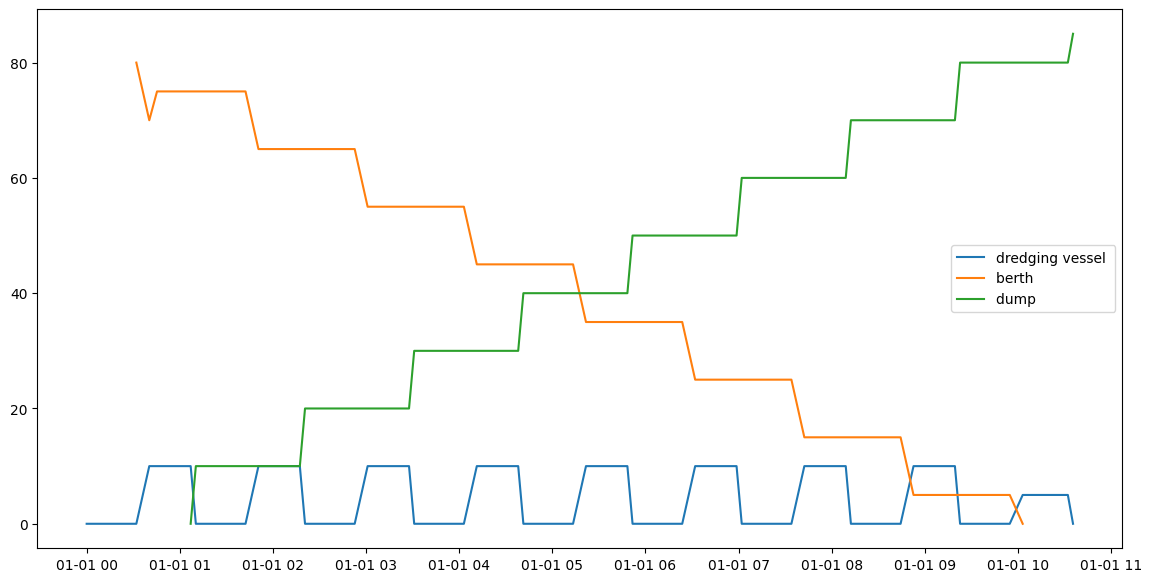

In [ ]:
fig = plot.get_step_chart([vessel01, berth, dump])

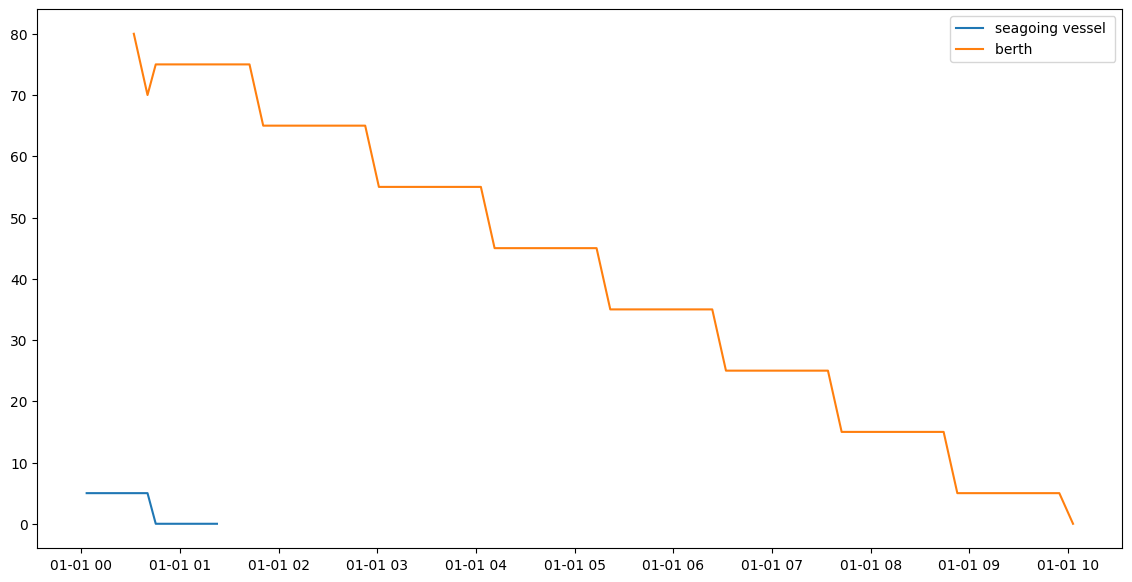

In [ ]:
fig = plot.get_step_chart([vessel02, berth, offshore])